#### Импорт необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint

#### Загрузка датасета

In [2]:
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names
target_names = wine.target_names

#### Преобразуем в DataFrame для удобства анализа

In [3]:
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['target_name'] = df['target'].map({0: target_names[0], 1: target_names[1], 2: target_names[2]})

#### Проверка на пропуски

In [4]:
print("Пропуски в данных:\n", df.isnull().sum())

Пропуски в данных:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
target_name                     0
dtype: int64


#### Разделение данных на обучающую и тестовую выборки

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Масштабирование данных (KNN чувствителен к масштабу)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Обучение модели KNN с произвольным K=5

In [7]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

#### Оценка качества модели

Оценка качества через accuracy, classification_report и confusion_matrix.

In [8]:
print("\n--- Исходная модель (K=5) ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))


--- Исходная модель (K=5) ---
Accuracy: 0.9444444444444444

Classification Report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      0.86      0.92        21
     class_2       0.83      1.00      0.91        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54



#### Матрица ошибок

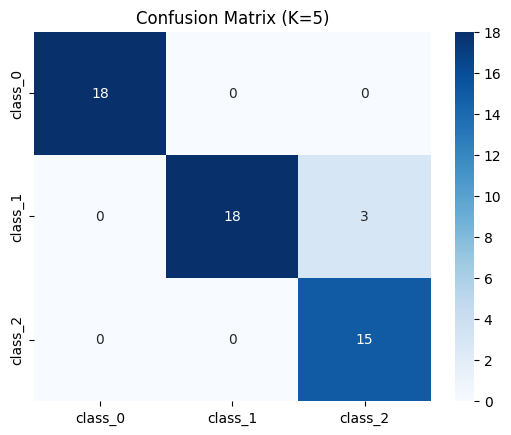

In [9]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix (K=5)")
plt.show()

#### Подбор гиперпараметра K с помощью GridSearchCV

GridSearchCV – полный перебор значений K от 1 до 20.

In [10]:
param_grid = {'n_neighbors': np.arange(1, 21)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print("\n--- GridSearchCV ---")
print("Лучший K:", grid_search.best_params_['n_neighbors'])
print("Лучшая точность:", grid_search.best_score_)


--- GridSearchCV ---
Лучший K: 11
Лучшая точность: 0.9756666666666666


#### Подбор гиперпараметра K с помощью RandomizedSearchCV

RandomizedSearchCV – случайный поиск (может быть быстрее на больших данных).

In [11]:
param_dist = {'n_neighbors': randint(1, 21)}
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_scaled, y_train)

print("\n--- RandomizedSearchCV ---")
print("Лучший K:", random_search.best_params_['n_neighbors'])
print("Лучшая точность:", random_search.best_score_)


--- RandomizedSearchCV ---
Лучший K: 11
Лучшая точность: 0.9756666666666666


#### Кросс-валидация с KFold и StratifiedKFold

[Кросс-валидация](https://blog.skillfactory.ru/chto-takoe-kross-validatsiya/)
- KFold – стандартная кросс-валидация.
- StratifiedKFold – сохраняет распределение классов.

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_optimal = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])

cv_scores_kfold = cross_val_score(knn_optimal, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
cv_scores_skfold = cross_val_score(knn_optimal, X_train_scaled, y_train, cv=skfold, scoring='accuracy')

print("\n--- Кросс-валидация ---")
print("KFold Accuracy (mean):", np.mean(cv_scores_kfold))
print("StratifiedKFold Accuracy (mean):", np.mean(cv_scores_skfold))


--- Кросс-валидация ---
KFold Accuracy (mean): 0.9593333333333334
StratifiedKFold Accuracy (mean): 0.96


#### Оценка оптимальной модели на тестовых данных

In [13]:
knn_optimal.fit(X_train_scaled, y_train)
y_pred_optimal = knn_optimal.predict(X_test_scaled)

print("\n--- Оптимальная модель ---")
print("Accuracy:", accuracy_score(y_test, y_pred_optimal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_optimal, target_names=target_names))


--- Оптимальная модель ---
Accuracy: 0.9629629629629629

Classification Report:
               precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      0.90      0.95        21
     class_2       0.88      1.00      0.94        15

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54



#### Сравнение исходной и оптимальной моделей

In [14]:
print("\n--- Сравнение моделей ---")
print(f"Исходная модель (K=5): Accuracy = {accuracy_score(y_test, y_pred):.4f}")
print(f"Оптимальная модель (K={grid_search.best_params_['n_neighbors']}): Accuracy = {accuracy_score(y_test, y_pred_optimal):.4f}")


--- Сравнение моделей ---
Исходная модель (K=5): Accuracy = 0.9444
Оптимальная модель (K=11): Accuracy = 0.9630
